# ML Exercise 3
## author: Lorenz Rumberger

## Task 1
Recall the linear regression model (in the multidimensional case)

$Y_i = \theta^T X_i + \epsilon_i , \epsilon_i \sim (0, \sigma^2)$

We have so far solved the parameter estimation problem using least squares. Let us now compute the fit using maximum likelihood.

a) Construct the likelihood function for linear regression. Use the shifting property of the normal distribution, i.e. $X \sim \mathcal{N}(z,\sigma^2) \leftrightarrow X = z + \epsilon$ , $\epsilon \sim \mathcal{N}(0,\sigma^2)$

$ p(Y_i | X_i, \theta, \sigma^2) = \mathcal{N}(\theta^T X_i, \sigma^2)$

$ L(\theta) = \prod\limits_{i = 1}^{n} p(Y_i | X_i, \theta, \sigma^2)$

Taking logs yields

$ \mathcal{l}(\theta) = \sum\limits_{i = 1}^{n} p(Y_i | X_i, \theta, \sigma^2)$

The PDF of the normal distribution is inserted for $ p(Y_i | X_i, \theta, \sigma^2)$

$ = \sum\limits_{i = 1}^{n} ln\Big((2 \pi \sigma^2)^{-\frac{1}{2}} exp\big(\frac{1}{2\sigma^2} (Y_i - X_i \theta)^2\big)\Big)$

$ = \sum\limits_{i = 1}^{n} -\frac{1}{2} ln(2 \pi \sigma^2) - \frac{1}{2\sigma^2} (Y_i - X_i \theta)^2$

Transformed to vectorized representation:

$ = -\frac{1}{2} ln(2 \pi \sigma^2) - \frac{1}{2\sigma^2} (Y - X \theta)^T (Y - X \theta)$

Compute the derivative of the log-likelihood function:

$ \frac{\partial \mathcal{l}(\theta)}{\partial \theta} = - \frac{1}{2 \sigma^2} \frac{\partial}{\partial \theta} (Y - X\theta)^T (Y - X\theta)$

$ = - \frac{1}{2 \sigma^2} \frac{\partial}{\partial \theta} (Y^T Y - 2 X^T X \theta + \theta^T X^T X \theta) $

Set the derivative equal to zero to find the optimum:

$ = - \frac{1}{2 \sigma^2} (- 2 X^T Y + 2 X^T X \theta) \stackrel{!}{=} 0 $

$ 2 X^T X \theta = 2 X^T Y |:2 |(X^TX)^{-1} $

$ \theta = (X^TX)^{-1} X^T Y$ 



## Task 2

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
adult = pd.DataFrame()
adult = pd.read_csv("adult2.csv", sep = ',')


## Prepare the data

In [0]:
# Transform variable workclass
adult.workclass = adult.workclass.str.replace('Self-emp-not-inc', 'self-employed')
adult.workclass = adult.workclass.str.replace('Self-emp-inc', 'self-employed')
adult.workclass = adult.workclass.str.replace('Federal-gov', 'government-employed')
adult.workclass = adult.workclass.str.replace('Local-gov', 'government-employed')
adult.workclass = adult.workclass.str.replace('State-gov', 'government-employed')
adult.workclass = adult.workclass.str.replace('Without-pay', 'unemployed')
adult.workclass = adult.workclass.str.replace('Never-worked', 'unemployed')


# Transform variable education
adult.education = adult.education.str.replace('Doctorate','higher education')
adult.education = adult.education.str.replace('Masters','higher education')
adult.education = adult.education.str.replace('Bachelors','higher education')
adult.education = adult.education.str.replace('HS-grad','high school')
adult.education = adult.education.str.replace('Some-college','high school')
adult.education = adult.education.str.replace('Assoc-acdm','high school')
adult.education = adult.education.str.replace('Prof-school','high school')
adult.education = adult.education.str.replace('Assoc-voc','high school')
# RE searches numbers like 1st, 8th, 11th and gives back 'lower education'
adult.education = adult.education.str.replace(r'\d+ ?(th|st)(-(\d+ ?(th|st)))*', 'lower education') 
adult.education = adult.education.str.replace('Preschool','lower education')

# Transform variable gender
adult.female = np.where(adult.gender == 'Female', 1, 0)

#Normalize data
def normalize(x):
    return(x - np.mean(x)) / (np.max(x) - np.min(x))

# Construct input X and output Y
X = pd.get_dummies(adult['workclass'])
X = X.assign(**pd.get_dummies(adult['education']))
X['female'] = adult.female
X['age'] = normalize(adult.age)
X['fnlwgt'] = normalize(adult.fnlwgt)
X['educational-num'] = normalize(adult['educational-num'])
X['capital-gain'] = normalize(adult['capital-gain'])
X['capital-los'] = normalize(adult['capital-loss'])
X['hours-per-week'] = normalize(adult['hours-per-week'])
X['intercept'] = np.ones(len(adult))
X['Y'] = pd.DataFrame(pd.get_dummies(adult['income'])['<=50K'])
X['?'] = X['?'].replace(1, np.nan)
X = X.dropna(axis=0, how='any')
X = X.drop(['unemployed'], axis=1)
X = X.drop(['lower education'], axis=1)
X = X.drop(['?'], axis=1)
Y = X['Y']
X = X.drop(['Y'], axis=1)
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
X = X.values
Y = Y.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [0]:
# Matrix Dimensions
# n = len(X)
# X         -> n x 13
# Y | z | h -> n x 1
# theta     -> 13 x 1
# grad      -> 13 x 1
# J         -> 1x1

# sigmoid squashing function
def sigmoid(z):
    return(1.0/(1 + np.exp(-z)))

# Cost function based on the negative log likelyhood value
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = -(1/m)* np.sum(y * np.log(h) + (1-y)*np.log(1-h))
    return(J)

def gradient(theta, X, y):
    m = y.size
    h = sigmoid(np.dot(X,theta))
    grad = (1/m)*np.dot(X.T,(h-y))
    return(grad.flatten())

def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

def accuracy(y,y_hat):
    m = y.size
    acc = 1 - np.sum(abs(y-y_hat))/m
    return acc
  
def gradient_descent(X_train, X_test, Y_train, Y_test, theta, LR, iter):
    acc = np.zeros(iter)
    convergence = 0
    for i in range(1, iter):
        J = costFunction(theta, X_train, Y_train)
        grad = gradient(theta, X_train, Y_train)
        theta = theta - (LR*grad)
        y_hat_test = predict(X_test, theta)
        acc[i] = accuracy(Y_test, y_hat_test)
        convergence = acc[i] - acc[i-1]
        if convergence < 0.0001:
            break
    return [theta, acc]

In [0]:
# Initialize theta
theta = (np.zeros(min(X.shape)))

[  4.12733355e-03   5.33469136e-04   3.21852491e-04   3.73832449e-03
   1.56405954e-04   2.48391616e-03   1.83790869e-03   6.39792102e-04
   2.69858440e-03  -8.91667491e-05  -2.11229608e-05   1.82364420e-03
   4.98888874e-03]


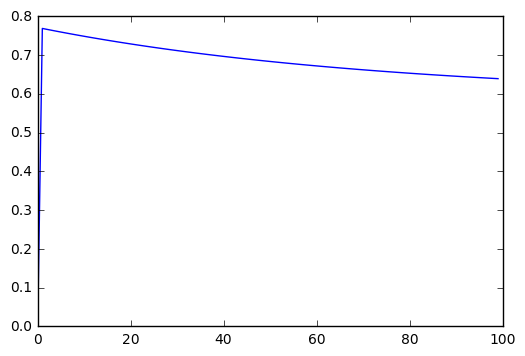

In [0]:
LearningRate = 0.01
[theta, acc] = gradient_descent(X_train, X_test, Y_train, Y_test, theta, LearningRate, 400)
plt.plot(list(range(len(cost))),cost)
print(theta)

In [0]:
iter = 99
acc_history = np.zeros(iter)
for i in range(0,iter):
    theta = (np.random.rand(min(X.shape))-0.5)
    [theta, acc] = gradient_descent(X_train, X_test, Y_train, Y_test, theta, 0.01, 400)
    acc_history[i] = max(acc)
acc_mu = np.mean(acc_history)
acc_max = max(acc_history)
print("Mean accuracy over 100 logistic regression fits is ",acc_mu,", max. accuracy among these models is ",acc_max)

Mean accuracy over 100 logistic regression fits is  0.6273956856 , max. accuracy among these models is  0.78314692149
